In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
from config import params, base_url
%matplotlib notebook

https://maps.googleapis.com/maps/api/geocode/json


In [ ]:
# Dependencies
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
from config import params, base_url

def wine_dropna(wine_data, col): 
    wine_data.dropna(subset=[col], inplace = True)
    print("wine_data size, after dropping NaN for "+ col + ": " + str(wine_data.shape))

def get_country_data(data, country): 
    ret_df = data.loc[data['country'] == country].copy()
    if ret_df.shape[0] > 0: 
        print('Record count for Country, ' + str(country) + ': ' + str(ret_df.shape))
        return ret_df
    else: 
        return None

def get_g_address(winery_geo): 

    formatted_address = winery_geo["results"][0]['formatted_address']
    formed_address_list = winery_geo["results"][0]['address_components']
    try: 
        street_number = formed_address_list[0]['long_name']
        route = formed_address_list[1]['long_name']
        locality = formed_address_list[2]['long_name']
        administrative_area_level_2 = formed_address_list[3]['long_name']
        administrative_area_level_1 = formed_address_list[4]['long_name']
        g_country = formed_address_list[5]['long_name']
        postal_code = formed_address_list[6]['long_name']
    except: 
        return None
    
    ret_data = (formatted_address, formed_address_list, 
                street_number, route, locality, 
                administrative_area_level_2, 
                administrative_area_level_1, 
                g_country, 
                postal_code)
    return ret_data

def check_match(formed_address, province, country): 
    return country != formed_address[7] or province != formed_address[5]

def write_results(out_path, content): 
    out_dir_name = os.path.dirname(out_path)

    if not os.path.exists(out_dir_name): 
        os.mkdir(out_dir_name, 511)
    file_name = os.path.split(out_path)[1]
    
    with open(os.path.join(out_dir_name, file_name), 'a') as ctx: 
        ctx.write(content)

wine_data = pd.read_csv('Data/winemag-data-130k-v2.csv')
wine_data.head()

cleaned_wine_data_ind_cntrs = wine_data.copy()
cleaned_wine_data_all_cntrs = wine_data.copy()

non_nullable_colums_for_individual_countries = [
                       'title', 
                       'price', 
                       'points',
                       'winery',  
                       'taster_name', 
                       'region_1'
                      ]

non_nullable_colums_for_all_countries = [
                       'title', 
                       'price', 
                       'points',
                       'winery',  
                       'taster_name'
                      ]

countries = list(cleaned_wine_data_ind_cntrs.country.unique())

print(countries)
print(len(countries))

for cols in non_nullable_colums_for_individual_countries: 
    wine_dropna(cleaned_wine_data_ind_cntrs, cols)
    
for cols in non_nullable_colums_for_all_countries: 
    wine_dropna(cleaned_wine_data_all_cntrs, cols)

data_columns_for_study = ['title', 'description', # Wine
                          'taster_name', 'taster_twitter_handle', 'points', 'price', # Rating
                          'variety', 'winery', # Wine Type
                          'province', 'region_1', 'country' # Area
                         ]
cleaned_wine_data_ind_cntrs = cleaned_wine_data_ind_cntrs[data_columns_for_study]
cleaned_wine_data_all_cntrs = cleaned_wine_data_all_cntrs[data_columns_for_study]

country_data = pd.DataFrame()
print(base_url)
unfound_winery = [{}]
for country in countries: 
    country_data = get_country_data(cleaned_wine_data_ind_cntrs, country)
    
    if isinstance(country_data, pd.DataFrame):
        if (country == 'Australia'): 
            print(country)
            country_data['latitude'] = ''
            country_data['longitude'] = ''
            country_data['g_address'] = ''
            country_data.index = pd.RangeIndex(len(country_data.index))
            address_dict = {}
            for index, row in country_data.iterrows(): 
                print(index)
                winery_address = f"{row['winery']} winery, {row['region_1']}, {row['province']}, {row['country']}"
                if not winery_address in address_dict.keys(): 
                    address_dict.update({winery_address: []})
                    params['address'] = winery_address
                    response = requests.get(base_url, params=params)
                    # print(response)
                    if response.status_code == 200:
                    # Extracting data in json format
                        winery_geo = response.json()
                        if winery_geo.get("results", []):
                            lat = winery_geo["results"][0]["geometry"]["location"]["lat"]
                            lon = winery_geo["results"][0]["geometry"]["location"]["lng"]
                        else: 
                            unfound_winery.append({'winery_address': f"{row['winery']} winery, {row['region_1']}, {row['province']}, {row['country']}"})
                            country_data.drop([index])
                            address_dict.pop(winery_address)
                            continue
                    formed_address = get_g_address(winery_geo)
                    if formed_address == None: 
                        unfound_winery.append({'winery_address': f"{row['winery']} winery, {row['region_1']}, {row['province']}, {row['country']}"})
                        country_data.drop([index])
                        address_dict.pop(winery_address)
                        continue
                    check_match_count = 0
                    is_winery_add_found = True
                    while not check_match(formed_address, row['province'], country): 
                        check_match_count += 1
                        params['address'] = f"{row['region_1']}, {row['province']}, {row['country']}"
                        response = requests.get(base_url, params=params)
                        winery_geo = response.json()
                        formed_address = get_g_address(winery_geo)
                        if check_match_count > 1: 
                            unfound_winery.append({'winery_address': f"{row['winery']} winery, {row['region_1']}, {row['province']}, {row['country']}"})
                            country_data.drop([index])
                            is_winery_add_found = False
                            address_dict.pop(winery_address)
                            break
                    if not is_winery_add_found: 
                        continue

                    formed_address = f'{formed_address[2]}~~~~{formed_address[3]}~~~~{formed_address[4]}~~~~{formed_address[5]}~~~~{formed_address[6]}~~~~{formed_address[7]}~~~~{formed_address[8]}'
                    
                    address_dict[winery_address] = [lat, lon, formed_address]
                    country_data.at[index, 'latitude'] = str(lat)
                    country_data.at[index, 'longitude'] = str(lon)
                    country_data.at[index, 'g_address'] = str(formed_address)
                    # print(f"Winery: {winery_address} ; LAT: {lat} ; LON: {lon}; Address: {formed_address}")
                else: 
                    lat = address_dict[winery_address][0]
                    lon = address_dict[winery_address][1]
                    formed_address = address_dict[winery_address][2]
                    country_data.at[index, 'latitude'] = str(lat)
                    country_data.at[index, 'longitude'] = str(lon)
                    country_data.at[index, 'g_address'] = str(formed_address)
            print(country_data.shape)
            country_data['g_address'].replace('', np.nan, inplace=True)
            wine_dropna(country_data, 'g_address')
            print(country_data.shape)
            country_data.to_excel('output.xlsx', sheet_name=country, float_format="%.12f")
    else: 
        continue
    
# print('--------------------------------------')
# for country in countries: 
#     country_data = get_country_data(cleaned_wine_data_all_cntrs, country)

print(unfound_winery)

In [46]:
countries = ['Australia', 'Canada', 'France', 'Italy', 'Spain', 'US']
comparison_data = {}
bar_data = {}
x_axis = np.arange(len(countries))
colors = ['r', 'g', 'b', 'y', 'm', 'c']
bar_width = 0.25
alp = 0.3
x_axis

array([0, 1, 2, 3, 4, 5])

In [47]:

for index, country in enumerate(countries): 
    datatrame_list = []
    file_name = 'output_' + country + '.xlsx'
    c_data = pd.read_excel(file_name)
    
    c_data = c_data.rename(index= str, columns={'title':'Title', 'description': 'Description',
                                                'taster_name': 'Sommelier', 'taster_twitter_handle':'Sommelier Twitter Acc.',
                                                'points': 'Points', 'price':"Price", 'variety': 'Variety', 'winery': 'Winery',
                                                'province':'State', 'region_1': 'County', 'latitude': 'Lat', 'longitude': "Lng",
                                                'g_address': 'Address'})
    
    winery_max_price = c_data.groupby(['Variety'])['Price'].max().to_frame()

    winery_max_points = c_data.groupby(['Variety'])['Points'].max().to_frame()
    
    winery_competitive_score = winery_max_price.merge(winery_max_points, how = 'inner', on = 'Variety')
    
    winery_competitive_score['Ratio'] = winery_competitive_score['Points'] / winery_competitive_score['Price']
    
    winery_competitive_score = winery_competitive_score.sort_values(by = 'Ratio', ascending = False)
    
    datatrame_list.append(winery_competitive_score)
    
    
    y_data = winery_competitive_score.reset_index()['Ratio'].tolist()
    y_data = [round(float(x), 2) for x in y_data[0:6]]
    print(f'{country}: {y_data}')
    bar_data[country] = y_data
    
    
    median_price_by_winery_variety_df = c_data.groupby(['Winery', 'Variety'])['Price'].median().to_frame()
    
    median_price_by_winery_variety_df = median_price_by_winery_variety_df.sort_values(by=["Price"], ascending = False)
    
    datatrame_list.append(median_price_by_winery_variety_df)
    
    comparison_data.update({country: datatrame_list})


Australia: [6.77, 5.93, 5.87, 5.87, 5.38, 5.18]
Canada: [6.92, 5.06, 4.74, 4.6, 4.5, 3.96]
France: [9.44, 8.6, 7.73, 7.42, 7.33, 7.08]
Italy: [7.33, 6.29, 6.14, 5.87, 5.56, 5.5]
Spain: [12.14, 10.62, 8.4, 8.2, 7.91, 7.64]
US: [8.6, 7.33, 6.77, 6.69, 5.88, 5.87]


In [ ]:
# for k, v_list in comparison_data.items(): 
#     print(k)
#     print('------------------')
#     print(v_list[0].head())

# country_df = {
#     "usa" : [df1]
# }
        
# print(len(comparison_data))
for df in comparison_data:
#     print(len(comparison_data[df]))
    print(df)
    print("------------------------------------")
    for index in range(len(comparison_data[df])):
        print(comparison_data[df][index])
        print("------------------------------------")

[[ 6.77  6.92  9.44  7.33 12.14  8.6 ]
 [ 5.93  5.06  8.6   6.29 10.62  7.33]
 [ 5.87  4.74  7.73  6.14  8.4   6.77]
 [ 5.87  4.6   7.42  5.87  8.2   6.69]
 [ 5.38  4.5   7.33  5.56  7.91  5.88]
 [ 5.18  3.96  7.08  5.5   7.64  5.87]]
[6.77, 6.92, 9.44, 7.33, 12.14, 8.6]


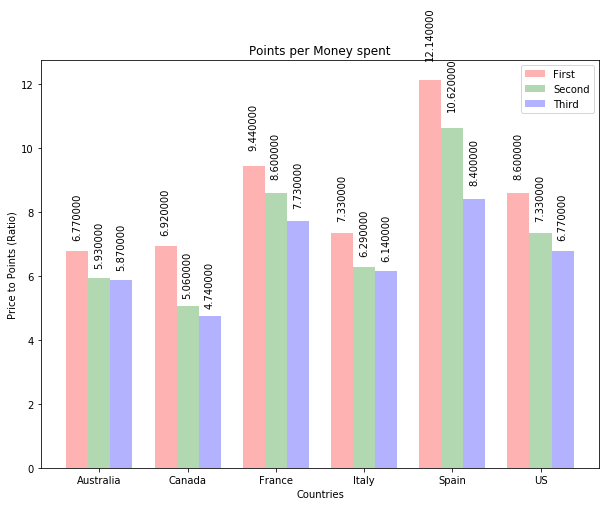

In [64]:

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%f'%h,
                ha='center', va='bottom', rotation = 'vertical')

x_axis = np.arange(len(countries))
legend_labels = ['First', 'Second', 'Third', 'Fourth', 'Fifth', 'Sixth']

y_axis_t = []
for index, country in enumerate(bar_data): 
    y_axis_t.append(bar_data[country])
y_axis_t = tuple(y_axis_t)
y_axis_arr = np.column_stack(y_axis_t)
print(y_axis_arr)

print(list(y_axis_arr[0]))

fig, ax = plt.subplots(figsize=(10,7.5))

box = []
# for index, country in enumerate(countries):
#     box.append(ax.bar(x_axis + (bar_width * (index+index)),
#                    y_axis_arr[index], bar_width, 
#                    color=colors[index], alpha = alp))

box.append(ax.bar(x_axis + (bar_width * (0 + 7)),
                   y_axis_arr[0], bar_width, 
                   color=colors[0], alpha = alp))
box.append(ax.bar(x_axis + (bar_width * (1 + 7)),
                   y_axis_arr[1], bar_width, 
                   color=colors[1], alpha = alp))
box.append(ax.bar(x_axis + (bar_width * (2 + 7)),
                   y_axis_arr[2], bar_width, 
                   color=colors[2], alpha = alp))


ax.set_xlabel('Countries')
ax.set_ylabel('Price to Points (Ratio)')
ax.set_title('Points per Money spent')
ax.set_xticks(x_axis + bar_width * 8)
ax.set_xticklabels(('Australia', 'Canada', 'France', 'Italy', 'Spain', 'US'))

ax.legend((box[0][0], box[1][0], 
           box[2][0]
#            , box[3][0], 
#            box[4][0], box[5][0]
          ), legend_labels)

for ind in range(3):
    autolabel(box[ind])